### Lets look into the dataset and see what we have

In [10]:
# import libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import shutil

In [11]:
data_dir = './data_raw'
os.listdir(data_dir)

['test1', 'train']

In [12]:
os.listdir(data_dir + '/train')

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg',
 'cat.10008.jpg',
 'cat.10009.jpg',
 'cat.1001.jpg',
 'cat.10010.jpg',
 'cat.10011.jpg',
 'cat.10012.jpg',
 'cat.10013.jpg',
 'cat.10014.jpg',
 'cat.10015.jpg',
 'cat.10016.jpg',
 'cat.10017.jpg',
 'cat.10018.jpg',
 'cat.10019.jpg',
 'cat.1002.jpg',
 'cat.10020.jpg',
 'cat.10021.jpg',
 'cat.10022.jpg',
 'cat.10023.jpg',
 'cat.10024.jpg',
 'cat.10025.jpg',
 'cat.10026.jpg',
 'cat.10027.jpg',
 'cat.10028.jpg',
 'cat.10029.jpg',
 'cat.1003.jpg',
 'cat.10030.jpg',
 'cat.10031.jpg',
 'cat.10032.jpg',
 'cat.10033.jpg',
 'cat.10034.jpg',
 'cat.10035.jpg',
 'cat.10036.jpg',
 'cat.10037.jpg',
 'cat.10038.jpg',
 'cat.10039.jpg',
 'cat.1004.jpg',
 'cat.10040.jpg',
 'cat.10041.jpg',
 'cat.10042.jpg',
 'cat.10043.jpg',
 'cat.10044.jpg',
 'cat.10045.jpg',
 'cat.10046.jpg',
 'cat.1004

In [4]:
cat_images = glob(data_dir + '/train/cat.*.jpg')
dog_images = glob(data_dir + '/train/dog.*.jpg')

print( "No. of cat images - ", len(cat_images))
print( "No. of dog images - ", len(dog_images))

No. of cat images -  12500
No. of dog images -  12500


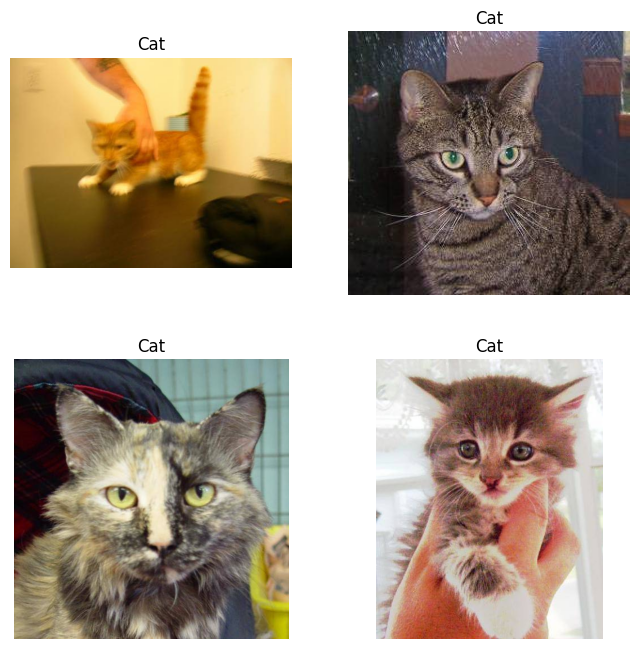

In [5]:
# Lets see some cat images
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = cv2.imread(cat_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Cat")
    plt.axis('off')

Looks like some images can be very blury. Images may not have full cat body and some might have human hands holding them. Backgrounds are different for each image. Images are from different shapes. 

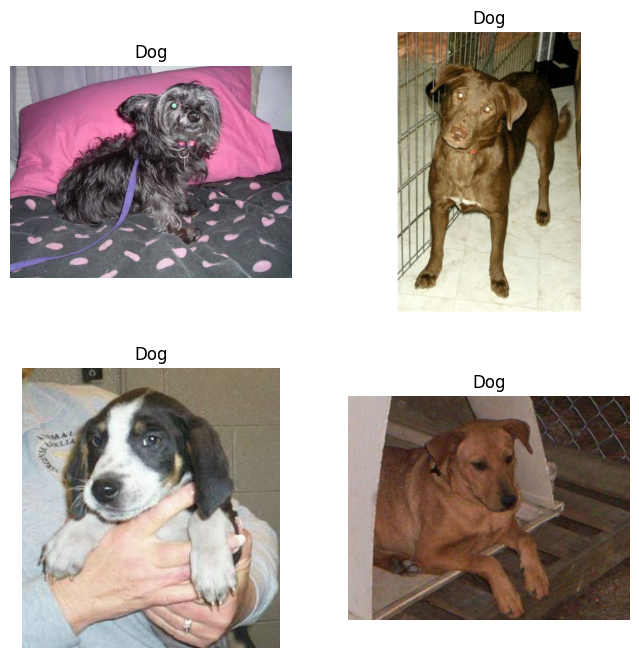

In [6]:
# Lets see some dog images
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = cv2.imread(dog_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Dog")
    plt.axis('off')

Same here. Different backgrounds, different lighting, oclusion, different breeds, human hands, different image shape etc.

### ML Pipeline

In [1]:
import os
import cv2
import copy

def applyCLAHE(image):
    clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
    cl = copy.deepcopy(image)
    cl = clahe.apply(cl)
    return cl


def applySobel(image):
    # Apply Sobel operator to obtain gradient images in the x and y directions
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude and direction using the x and y gradients
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_dir = np.arctan2(grad_y, grad_x)

    return grad_dir

def applyLoG(image):
    # Apply Gaussian smoothing with a kernel size of 5
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Laplacian filter with a data type of 64-bit float
    img_lap = cv2.Laplacian(img_blur, cv2.CV_64F)

    # Convert the Laplacian output to an 8-bit unsigned integer
    img_lap = np.uint8(np.absolute(img_lap))

    return img_lap

def applyBen(img, size):
    img=cv2.addWeighted(img ,4, cv2.GaussianBlur(img, (0,0) , size/30) , -4, 128)
    return img

def applyGamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

# Pre-processing the images
def preprocessing(input_dir, output_dir, grayscale = True, photo_norm = "CLAHE", edge_detection = None, resize_shape = 128):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Loop through all files in the input folder
    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Check if the file is a valid image
        if img is None:
            print(f"Skipping non-image file: {filename}")
            continue

        # Convert the image to grayscale
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE to the grayscale image
        if photo_norm == "CLAHE":
            img = clahe.apply(img)
        elif photo_norm == "AHE":
            img = cv2.equalizeHist(img)
        else:
            pass

        if edge_detection == 'canny':
            img = cv2.Canny(img, threshold1=100, threshold2=200)
        elif edge_detection == 'sobel':
            # Calculate gradient along X and Y direction
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

            # Calculate the magnitude of the gradient
            img = cv2.magnitude(sobelx, sobely)

            # Convert the result back to 8-bit format
            img = cv2.convertScaleAbs(img)
        else:
            pass

        # Resize the image to the specified size
        img = cv2.resize(img, (resize_shape, resize_shape))

        # Save the processed image in the output folder
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, img)


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern

# Parameters for LBP
RADIUS = 1
N_POINTS = 8 * RADIUS

# Feature extraction function
def feature_extraction(input_dir, feats):
    feature_list = []  # To store features for each image
    image_names = []   # To store image file names
    labels = []        # To store labels (1 for cat, 0 for dog)
    
    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        
        # Read the image using OpenCV
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Ensure grayscale
        
        if img is None:
            print(f"Skipping non-image file: {filename}")
            continue
        
        features = []  # To store features for the current image
        
        # Extract HOG features if requested
        if 'hog' in feats:
            hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
            features.extend(hog_features)
        
        # Extract LBP features if requested
        if 'lbp' in feats:
            lbp_image = local_binary_pattern(img, N_POINTS, RADIUS, method="uniform")
            (lbp_hist, _) = np.histogram(lbp_image.ravel(),
                                         bins=np.arange(0, N_POINTS + 3),
                                         range=(0, N_POINTS + 2))
            # Normalize LBP histogram
            lbp_hist = lbp_hist.astype("float")
            lbp_hist /= (lbp_hist.sum() + 1e-6)
            features.extend(lbp_hist)
        
        # Append features and image name to lists
        feature_list.append(features)
        image_names.append(filename)
        
        # Assign label based on the first three letters of the filename
        if filename[:3].lower() == 'cat':
            labels.append(1)  # Label 1 for cat
        elif filename[:3].lower() == 'dog':
            labels.append(0)  # Label 0 for dog
        else:
            print(f"Unknown label for {filename}")
            labels.append(-1)  # Unknown label (just for safety)

    # Create a DataFrame with image names, features, and labels
    feature_df = pd.DataFrame(feature_list)
    feature_df.insert(0, 'image_name', image_names)  # Add image name as first column
    feature_df['label'] = labels  # Add label as the last column
    
    return feature_df

# Example usage
# feats = ['hog', 'lbp']
# processed_data_dir = "path/to/processed/images"
# feat_df = feature_extraction(processed_data_dir, feats)
# print(feat_df.head())


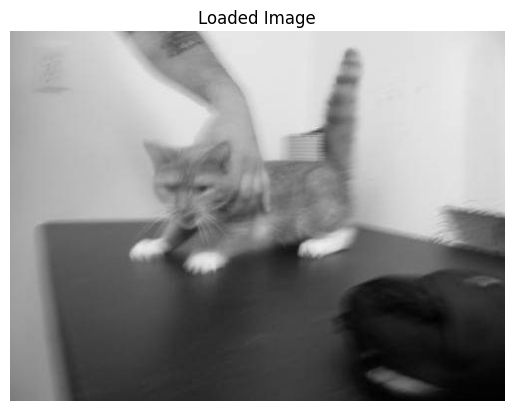

In [14]:
# Load an image using OpenCV
import cv2
import matplotlib.pyplot as plt

image_path = './data_raw/train/cat.0.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    # Convert the image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.title('Loaded Image')
    plt.axis('off')
    plt.show()

In [17]:
# img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img = cv2.resize(image, (32, 32))

In [18]:
# feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
#                                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
# feat.shape

# hyper parameter tune hog features
# LBP features and SVM
# on smaller dataset

(324,)

In [9]:
raw_data_dir = './data_raw/train'
processed_data_dir = './data_preprocessed'
feats = ['hog', 'lbp']

In [6]:

preprocessing(raw_data_dir, processed_data_dir, grayscale=True, photo_norm="CLAHE", edge_detection=None, resize_shape=128)

In [18]:

feat_df = feature_extraction(processed_data_dir, feats)

In [19]:
feat_df.to_pickle('features_hog_lbp.pkl')

In [10]:
feat_df = pd.read_pickle('features_hog_lbp.pkl')

In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
import pickle

def ml_train(data, models, target='label', k_fold=5, shuffle=False, save_results=True, output_dir = './results'):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Prepare features and target variable
    X = data.drop(columns=[target, 'image_name'])
    y = data[target]

    # Initialize KFold
    kf = StratifiedKFold(n_splits=k_fold, shuffle=shuffle)
    kf.get_n_splits(X,y)

    params = { 'random_state':42,'verbose': -1}

    # Model mapping
    model_mapping = {
        'logistic': LogisticRegression(max_iter=1000),
        'decision_tree': DecisionTreeClassifier(),
        'random_forest': RandomForestClassifier(),
        'svm': SVC(),
        'knn': KNeighborsClassifier(),
        'naive_bayes': GaussianNB(),
        'gbm': GradientBoostingClassifier(),
        'xgboost': xgb.XGBClassifier(eval_metric='logloss'),
        'lightgbm': lgb.LGBMClassifier(**params),
        'catboost': CatBoostClassifier(silent=True),
        'mlp': MLPClassifier(max_iter=1000)
    }

    results = []

    for model_name in models:
        if model_name not in model_mapping:
            print(f"Model '{model_name}' is not recognized.")
            continue
        
        model = model_mapping[model_name]
        fold_accuracies = []
        fold_confusions = []
        fold_predictions = []
        

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_test_image_name = data['image_name'].iloc[test_index]

            # Feature normalization
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            fold_accuracies.append(accuracy)

            # Calculate confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            fold_confusions.append(conf_matrix)

            # Store predictions
            fold_predictions.append(pd.DataFrame({'image_name': y_test_image_name, 'label': y_test, 'prediction': y_pred}))


        # Calculate mean accuracy and average confusion matrix
        mean_accuracy = np.mean(fold_accuracies)
        # avg_confusion = np.mean(fold_confusions, axis=0)

        # Store results
        results.append({
            'model': model_name,
            'mean_accuracy': mean_accuracy,
            'fold_accuracies': fold_accuracies,
            'CMs': fold_confusions,
            'predictions': fold_predictions
        })
        print(f"Model: {model_name.capitalize()} | Mean Accuracy: {mean_accuracy:.2f}")
    if save_results:
        # save results as pickle
        with open(os.path.join(output_dir, f'results.pkl'), 'wb') as f:
            pickle.dump(results, f)

    return 

# Example usage
# results = ml_train(data=feat_df, 
#                    models=ml_models, 
#                    target='label', 
#                    k_fold=5, 
#                    shuffle=False, 
#                    save_results=True, 
#                    output_dir='./results')


In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

def ml_train(data, models, target='label', k_fold=5, shuffle=False, save_results=True, output_dir='./results'):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Prepare features and target variable
    X = data.drop(columns=[target, 'image_name'])
    y = data[target]

    # Initialize KFold
    kf = StratifiedKFold(n_splits=k_fold, shuffle=shuffle)
    kf.get_n_splits(X, y)

    params = {'random_state': 42, 'verbose': -1}

    # Model mapping
    model_mapping = {
        'logistic': LogisticRegression(max_iter=1000),
        'decision_tree': DecisionTreeClassifier(),
        'random_forest': RandomForestClassifier(),
        'svm': SVC(probability=True),  # Set probability=True for soft voting
        'knn': KNeighborsClassifier(),
        'naive_bayes': GaussianNB(),
        'gbm': GradientBoostingClassifier(),
        'xgboost': XGBClassifier(eval_metric='logloss'),
        'lightgbm': lgb.LGBMClassifier(**params),
        'catboost': CatBoostClassifier(silent=True),
        'mlp': MLPClassifier(max_iter=1000),
        'ensemble': VotingClassifier(estimators=[
            ('svm', SVC(probability=True)),
            ('mlp', MLPClassifier(max_iter=1000)),
            ('xgboost', XGBClassifier(eval_metric='logloss'))
        ], voting='soft')  # Using soft voting for better performance
    }

    results = []

    for model_name in models:
        if model_name not in model_mapping:
            print(f"Model '{model_name}' is not recognized.")
            continue

        model = model_mapping[model_name]
        fold_accuracies = []
        fold_confusions = []
        fold_predictions = []

        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            y_test_image_name = data['image_name'].iloc[test_index]

            # Feature normalization
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            fold_accuracies.append(accuracy)

            # Calculate confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            fold_confusions.append(conf_matrix)

            # Store predictions
            fold_predictions.append(pd.DataFrame({'image_name': y_test_image_name, 'label': y_test, 'prediction': y_pred}))

        # Calculate mean accuracy and average confusion matrix
        mean_accuracy = np.mean(fold_accuracies)

        # Store results
        results.append({
            'model': model_name,
            'mean_accuracy': mean_accuracy,
            'fold_accuracies': fold_accuracies,
            'CMs': fold_confusions,
            'predictions': fold_predictions
        })
        print(f"Model: {model_name.capitalize()} | Mean Accuracy: {mean_accuracy:.2f}")

    if save_results:
        # Save results as pickle
        with open(os.path.join(output_dir, f'results.pkl'), 'wb') as f:
            pickle.dump(results, f)

    return results


In [16]:
'''
'logistic',
 'decision_tree', 
 'random_forest', 
 'svm',
 'knn',
 'naive_bayes',
 'gbm', 
 'xgboost', 
 'lightgbm', 
 'catboost', 
 'mlp'
'''
# ml_models = ['decision_tree', 'random_forest', 'svm', 'xgboost', 'mlp']
ml_models = ['ensemble']
feat_df.columns = feat_df.columns.astype(str)
ml_train (data=feat_df, 
                    models=ml_models, 
                    target='label', 
                    k_fold = 5, 
                    shuffle = False, 
                    save_results = True, 
                    output_dir = './results_train_ensamble')

### *Results and retrain 32x32*

In [7]:
# at first lets look at the confusion matrix for top models 

import pickle 
import os

# Load the results from the saved pickle file
results_dir = './results_train3'
# results_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl')]
# results = []

results = pickle.load(open(os.path.join(results_dir, 'results.pkl'), 'rb'))
results

[{'model': 'decision_tree',
  'mean_accuracy': 0.5944,
  'fold_accuracies': [0.6004, 0.6002, 0.592, 0.591, 0.5884],
  'CMs': [array([[1522,  978],
          [1020, 1480]], dtype=int64),
   array([[1493, 1007],
          [ 992, 1508]], dtype=int64),
   array([[1470, 1030],
          [1010, 1490]], dtype=int64),
   array([[1490, 1010],
          [1035, 1465]], dtype=int64),
   array([[1461, 1039],
          [1019, 1481]], dtype=int64)],
  'predictions': [          image_name  label  prediction
   0          cat.0.jpg      1           1
   1          cat.1.jpg      1           1
   2         cat.10.jpg      1           1
   3        cat.100.jpg      1           1
   4       cat.1000.jpg      1           0
   ...              ...    ...         ...
   14995  dog.12242.jpg      0           0
   14996  dog.12243.jpg      0           0
   14997  dog.12244.jpg      0           0
   14998  dog.12245.jpg      0           0
   14999  dog.12246.jpg      0           1
   
   [5000 rows x 3 columns]

In [8]:
len (results)

5

In [11]:
results[2]['CMs']

[array([[1920,  580],
        [ 593, 1907]], dtype=int64),
 array([[1908,  592],
        [ 534, 1966]], dtype=int64),
 array([[1901,  599],
        [ 553, 1947]], dtype=int64),
 array([[1904,  596],
        [ 594, 1906]], dtype=int64),
 array([[1905,  595],
        [ 551, 1949]], dtype=int64)]

svm


Text(0.5, 1.0, 'Confusion Matrix')

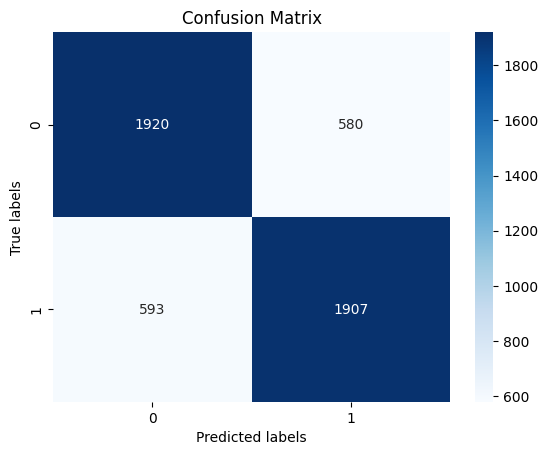

In [12]:
print(results[2]['model'])
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix for the first fold
cm = results[2]['CMs'][0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')



Fold 1 | Accuracy: 0.77


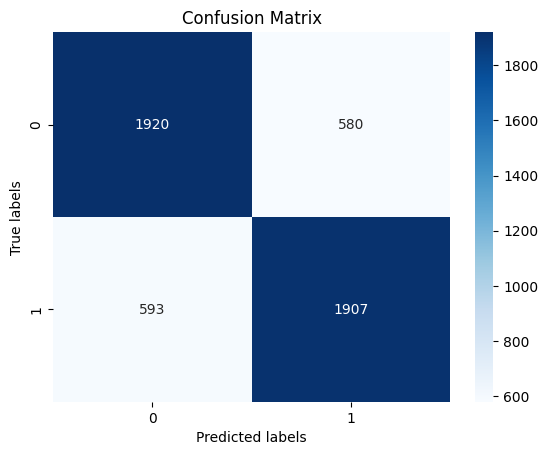

Fold 2 | Accuracy: 0.77


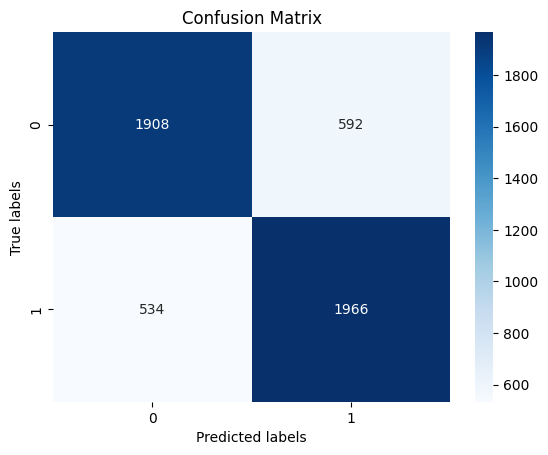

Fold 3 | Accuracy: 0.77


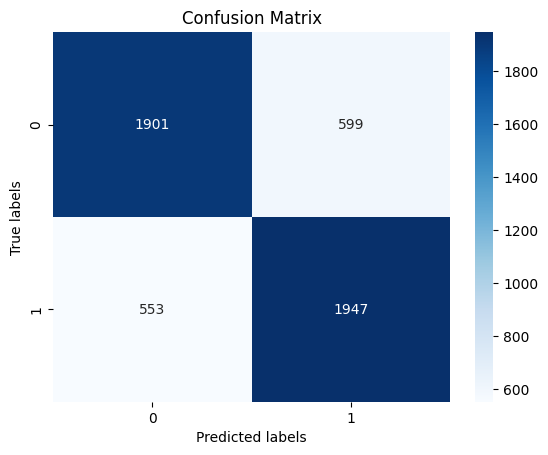

Fold 4 | Accuracy: 0.76


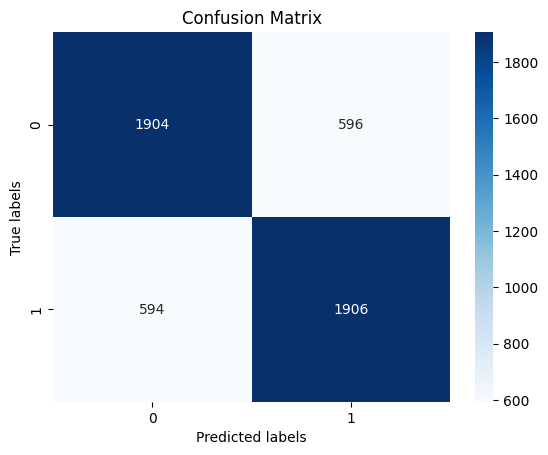

Fold 5 | Accuracy: 0.77


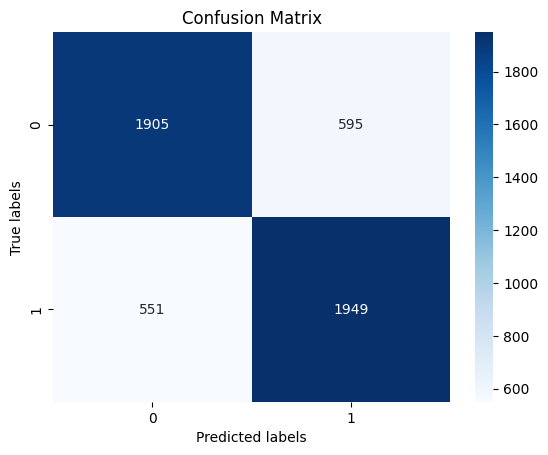

In [13]:
for fold in range(5):
    print(f"Fold {fold + 1} | Accuracy: {results[2]['fold_accuracies'][fold]:.2f}")
    cm = results[2]['CMs'][fold]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
raw_data_dir = './data_raw/train'
processed_data_dir = './data_32'
feats = ['hog', 'lbp']

preprocessing(raw_data_dir, processed_data_dir, grayscale=True, photo_norm="CLAHE", edge_detection=None, resize_shape=32)

In [15]:
feat_df = feature_extraction(processed_data_dir, feats)

In [16]:
feat_df.to_pickle('features32_hog_lbp.pkl')

In [17]:
ml_models = ['decision_tree', 'random_forest', 'svm', 'xgboost', 'mlp']
feat_df.columns = feat_df.columns.astype(str)
ml_train (data=feat_df, 
                    models=ml_models, 
                    target='label', 
                    k_fold = 5, 
                    shuffle = False, 
                    save_results = True, 
                    output_dir = './results_train32')

Model: Decision_tree | Mean Accuracy: 0.60
Model: Random_forest | Mean Accuracy: 0.71
Model: Svm | Mean Accuracy: 0.75
Model: Xgboost | Mean Accuracy: 0.72
Model: Mlp | Mean Accuracy: 0.69


In [ ]:
# feature 1ta 2ta and milia dekhte hobe
# Hyper parameter tuning
# Classifer - bag boost and ensamble
# deadline Monday - Present here on monday
# Friday online class


# lightening cable ase?


### Finding the missclassifications

In [18]:
# lets load results 

results = pickle.load(open(os.path.join('./results_train32', 'results.pkl'), 'rb'))
results 

[{'model': 'decision_tree',
  'mean_accuracy': 0.60168,
  'fold_accuracies': [0.6062, 0.605, 0.607, 0.594, 0.5962],
  'CMs': [array([[1539,  961],
          [1008, 1492]], dtype=int64),
   array([[1529,  971],
          [1004, 1496]], dtype=int64),
   array([[1530,  970],
          [ 995, 1505]], dtype=int64),
   array([[1513,  987],
          [1043, 1457]], dtype=int64),
   array([[1487, 1013],
          [1006, 1494]], dtype=int64)],
  'predictions': [          image_name  label  prediction
   0          cat.0.jpg      1           1
   1          cat.1.jpg      1           0
   2         cat.10.jpg      1           1
   3        cat.100.jpg      1           0
   4       cat.1000.jpg      1           1
   ...              ...    ...         ...
   14995  dog.12242.jpg      0           0
   14996  dog.12243.jpg      0           1
   14997  dog.12244.jpg      0           1
   14998  dog.12245.jpg      0           1
   14999  dog.12246.jpg      0           1
   
   [5000 rows x 3 columns]

Fold 1 | Accuracy: 0.75


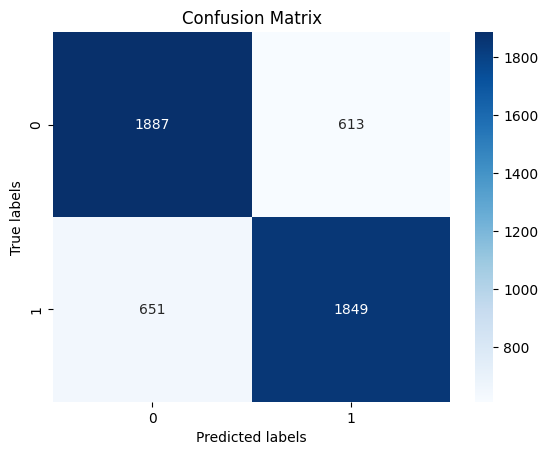

Fold 2 | Accuracy: 0.75


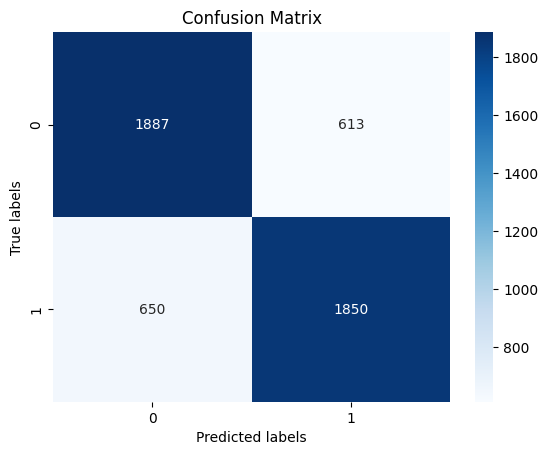

Fold 3 | Accuracy: 0.75


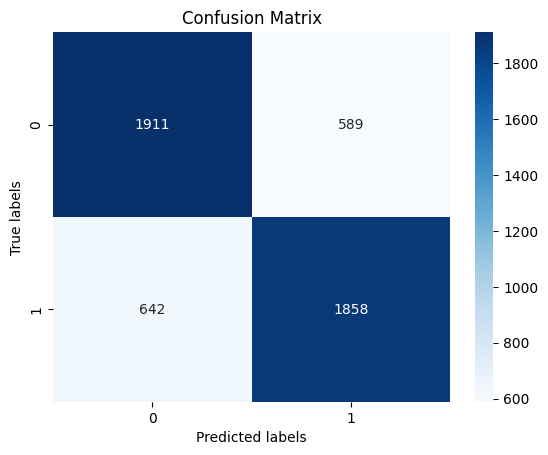

Fold 4 | Accuracy: 0.74


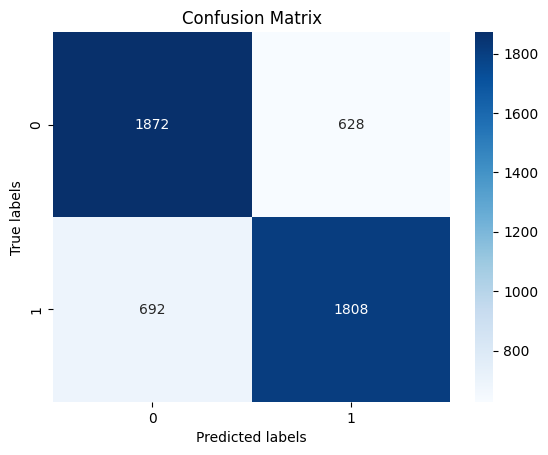

Fold 5 | Accuracy: 0.75


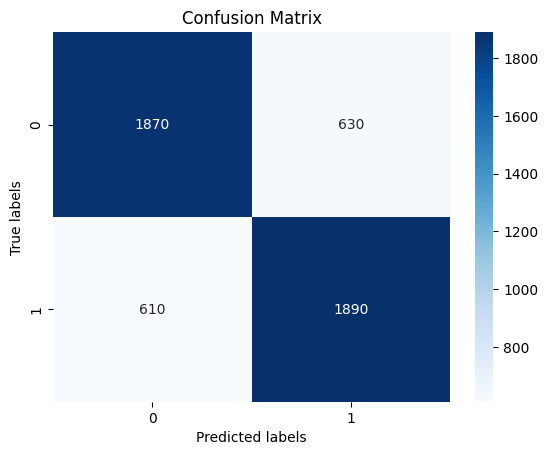

In [21]:
# lets look at the confusion matrix for top SVM model

for fold in range(5):
    print(f"Fold {fold + 1} | Accuracy: {results[2]['fold_accuracies'][fold]:.2f}")
    cm = results[2]['CMs'][fold]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
svm_results = results[2]
svm_results.keys()

dict_keys(['model', 'mean_accuracy', 'fold_accuracies', 'CMs', 'predictions'])

In [23]:
svm_preds = pd.concat(svm_results['predictions'])
svm_preds

image_name  label  prediction
0         cat.0.jpg      1           1
1         cat.1.jpg      1           0
2        cat.10.jpg      1           1
3       cat.100.jpg      1           0
4      cat.1000.jpg      1           1
...             ...    ...         ...
24995  dog.9995.jpg      0           1
24996  dog.9996.jpg      0           0
24997  dog.9997.jpg      0           0
24998  dog.9998.jpg      0           0
24999  dog.9999.jpg      0           1

[25000 rows x 3 columns]

In [24]:
misclassified = svm_preds[svm_preds['label'] != svm_preds['prediction']]
misclassified

image_name  label  prediction
1          cat.1.jpg      1           0
3        cat.100.jpg      1           0
7      cat.10002.jpg      1           0
13     cat.10008.jpg      1           0
16     cat.10010.jpg      1           0
...              ...    ...         ...
24984   dog.9985.jpg      0           1
24985   dog.9986.jpg      0           1
24994   dog.9994.jpg      0           1
24995   dog.9995.jpg      0           1
24999   dog.9999.jpg      0           1

[6318 rows x 3 columns]

In [26]:
import shutil
os.makedirs('./misclassified_images/', exist_ok=True)
for image_name in misclassified['image_name']:
    shutil.copy(os.path.join('./data_raw/train/', image_name), './misclassified_images/')

In [27]:
# delete the discarded images from processed files 
for image_name in os.listdir('./discard/'):
    os.remove(os.path.join('./data_32/', image_name))

In [33]:
feat_df = feature_extraction('./data_32', ['hog', 'lbp'])
feat_df.to_pickle('features32_rm40_hog_lbp.pkl')

In [34]:
ml_models = ['svm']
feat_df.columns = feat_df.columns.astype(str)
ml_train (data=feat_df, 
                    models=ml_models, 
                    target='label', 
                    k_fold = 5, 
                    shuffle = False, 
                    save_results = True, 
                    output_dir = './results_train32_RM40')

Model: Svm | Mean Accuracy: 0.75


In [35]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.datasets import load_breast_cancer 
from sklearn.svm import SVC 

In [38]:
from sklearn.model_selection import train_test_split
# Load the dataset
X = feat_df.drop(columns=['image_name', 'label'])
y = feat_df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [39]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.714 total time=  59.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.701 total time=  59.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time=  58.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time= 1.0min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.715 total time= 1.0min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.718 total time=  57.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.698 total time=  57.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.708 total time= 1.0min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.709 total time= 1.0min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.711 total time=  58.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.675 total time= 1.2min
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [40]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [41]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      2496
           1       0.76      0.72      0.74      2496

    accuracy                           0.74      4992
   macro avg       0.74      0.74      0.74      4992
weighted avg       0.74      0.74      0.74      4992



### Trying different pre-processing

In [1]:
import os
import cv2
import copy

def applyCLAHE(image):
    clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
    cl = copy.deepcopy(image)
    cl = clahe.apply(cl)
    return cl


def applySobel(image):
    # Apply Sobel operator to obtain gradient images in the x and y directions
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude and direction using the x and y gradients
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_dir = np.arctan2(grad_y, grad_x)

    return grad_dir

def applyLoG(image):
    # Apply Gaussian smoothing with a kernel size of 5
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Laplacian filter with a data type of 64-bit float
    img_lap = cv2.Laplacian(img_blur, cv2.CV_64F)

    # Convert the Laplacian output to an 8-bit unsigned integer
    img_lap = np.uint8(np.absolute(img_lap))

    return img_lap

def applyBen(img, size):
    img=cv2.addWeighted(img ,4, cv2.GaussianBlur(img, (0,0) , size/30) , -4, 128)
    return img

def applyGamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def apply_AHE(image):
    img = cv2.equalizeHist(image)
    return img

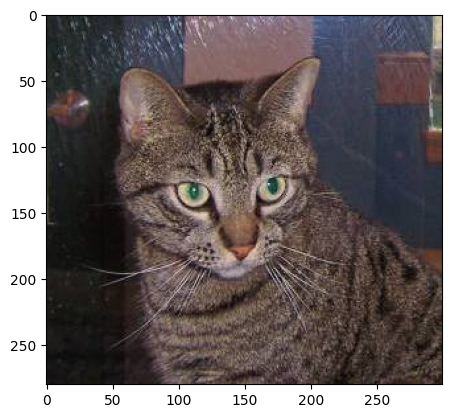

In [4]:
import matplotlib.pyplot as plt
a_image = cv2.imread('./data_raw/train/cat.1.jpg')
a_image = cv2.cvtColor(a_image, cv2.COLOR_BGR2RGB)
plt.imshow(a_image)

In [ ]:
# Different types of image processing techniques


# Baseline

In [56]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from glob import glob

# Set paths
dataset_path = './data_raw/train/'  # Set your dataset path
categories = ['cat', 'dog']

# Parameters
img_size = (32, 32)  # Resizing images to 128x128

# Function to load and preprocess images
def load_images(dataset_path, categories, img_size):
    data = []
    labels = []
    
    for category in categories:
        images = glob(os.path.join(dataset_path, f'{category}*'))  # Correct path concatenation
        # len_images = len(images)
        # print(f'Found {len_images} images for category: {category}')
        
        for img_path in images:
            try:
                # Load the image, resize and convert to grayscale
                img = load_img(img_path, target_size=img_size)
                img = img.convert('L')  # Convert image to grayscale (mode 'L')
                
                img_array = img_to_array(img)  # Convert to numpy array
                # print(img_array.shape)  # Print the shape after conversion
                
                data.append(img_array)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_images(dataset_path, categories, img_size)

# Normalize pixel values (0 to 255 -> 0 to 1)
data = data / 255.0

# Encode labels (cats -> 0, dogs -> 1)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Flatten the images from (32, 32, 3) to (32*32*3,)
n_samples, h, w, c = data.shape
data_flattened = data.reshape(n_samples, h * w * c)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_flattened, labels, test_size=0.2, random_state=42, stratify=labels)

# Baseline model - Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Baseline Accuracy: {accuracy:.4f}')

Baseline Accuracy: 0.6294


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1762,  738],
       [1009, 1491]], dtype=int64)

# with feature extraction from RGB

In [17]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to extract color histograms from RGB image
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
    return hist

# Function to extract HOG features from RGB image
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features

# Function to load images and extract features
def load_images_and_extract_features(dataset_path, categories, img_size, feature_type='combined'):
    data = []
    labels = []
    for category in categories:
        images = glob(dataset_path +f'{category}*')
        for img_path in images:
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img).astype('uint8')

                if feature_type == 'histogram':
                    features = extract_color_histogram(img_array)
                elif feature_type == 'hog':
                    features = extract_hog_features(img_array)
                elif feature_type == 'combined':
                    color_hist = extract_color_histogram(img_array)
                    hog_features = extract_hog_features(img_array)
                    features = np.hstack([color_hist, hog_features])
                else:
                    raise ValueError("Invalid feature type specified.")
                
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Common parameters
img_size = (32, 32)
dataset_path = './data_raw/train/'
categories = ['cat', 'dog']

# Encode labels
label_encoder = LabelEncoder()

# Function to train and evaluate model
def train_and_evaluate(feature_type):
    # Load data and extract features
    data, labels = load_images_and_extract_features(dataset_path, categories, img_size, feature_type)
    
    # Encode labels
    labels = label_encoder.fit_transform(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy using {feature_type.capitalize()} features: {accuracy:.4f}")
    print(confusion_matrix(y_test, y_pred))
    return accuracy

# Evaluate models with different feature extraction techniques
print("Training with Color Histogram Features:")
accuracy_histogram = train_and_evaluate('histogram')

print("\nTraining with HOG Features:")
accuracy_hog = train_and_evaluate('hog')

print("\nTraining with Combined Features (Color Histogram + HOG):")
accuracy_combined = train_and_evaluate('combined')


Training with Color Histogram Features:
Accuracy using Histogram features: 0.6692
[[1738  762]
 [ 892 1608]]

Training with HOG Features:
Accuracy using Hog features: 0.6934
[[1838  662]
 [ 871 1629]]

Training with Combined Features (Color Histogram + HOG):
Accuracy using Combined features: 0.7148
[[1941  559]
 [ 867 1633]]


In [53]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob

# Function to extract color histograms from RGB image
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
    return hist

# Function to extract HOG features from RGB image
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features

# Function to extract LBP features from grayscale image
def extract_lbp_features(image, radius=1, n_points=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, n_points * radius, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize the histogram
    return hist

# Function to load images and extract features
def load_images_and_extract_features(dataset_path, categories, img_size, feature_type='combined'):
    data = []
    labels = []
    for category in categories:
        images = glob(dataset_path + f'{category}*')
        for img_path in images:
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img).astype('uint8')

                if feature_type == 'histogram':
                    features = extract_color_histogram(img_array)
                elif feature_type == 'hog':
                    features = extract_hog_features(img_array)
                elif feature_type == 'lbp':
                    features = extract_lbp_features(img_array)
                elif feature_type == 'lbp_hog':
                    lbp_features = extract_lbp_features(img_array)
                    hog_features = extract_hog_features(img_array)
                    features = np.hstack([lbp_features, hog_features])
                elif feature_type == 'combined':
                    color_hist = extract_color_histogram(img_array)
                    hog_features = extract_hog_features(img_array)
                    lbp_features = extract_lbp_features(img_array)
                    features = np.hstack([color_hist, hog_features, lbp_features])
                else:
                    raise ValueError("Invalid feature type specified.")
                
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Common parameters
img_size = (32, 32)
dataset_path = './data_raw/train/'
categories = ['cat', 'dog']

# Encode labels
label_encoder = LabelEncoder()

# Function to train and evaluate model
def train_and_evaluate(feature_type):
    # Load data and extract features
    data, labels = load_images_and_extract_features(dataset_path, categories, img_size, feature_type)
    
    # Encode labels
    labels = label_encoder.fit_transform(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy using {feature_type.upper()} features: {accuracy:.4f}")
    print(confusion_matrix(y_test, y_pred))
    return accuracy

# # Evaluate models with different feature extraction techniques
# print("Training with LBP Features:")
# accuracy_lbp = train_and_evaluate('lbp')

feat = 'lbp'
print(f"\nTraining with {feat} Features:")
accuracy_lbp_hog = train_and_evaluate(feat)



Training with lbp Features:
Accuracy using LBP features: 0.6400
[[1674  826]
 [ 974 1526]]


# Pre-processing and RGB

In [24]:
# Function to apply CLAHE and Gaussian Blur preprocessing to RGB image
def preprocess_image(image, apply_clahe=True, apply_blur=True, blur_kernel=(5, 5)):
    # Convert to LAB color space for CLAHE
    if apply_clahe:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        lab = cv2.merge((cl, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply Gaussian Blur
    if apply_blur:
        image = cv2.GaussianBlur(image, blur_kernel, 0)
    
    return image

# Update the load_images_and_extract_features function to include preprocessing
def load_images_and_extract_features(dataset_path, categories, img_size, feature_type='combined', apply_clahe=True, apply_blur=True):
    data = []
    labels = []
    for category in categories:
        images = glob(dataset_path + f'{category}*')
        for img_path in images:
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img).astype('uint8')

                # Apply preprocessing before feature extraction
                img_array = preprocess_image(img_array, apply_clahe, apply_blur)

                # Feature extraction (as before)
                if feature_type == 'histogram':
                    features = extract_color_histogram(img_array)
                elif feature_type == 'hog':
                    features = extract_hog_features(img_array)
                elif feature_type == 'lbp':
                    features = extract_lbp_features(img_array)
                elif feature_type == 'lbp_hog':
                    lbp_features = extract_lbp_features(img_array)
                    hog_features = extract_hog_features(img_array)
                    features = np.hstack([lbp_features, hog_features])
                elif feature_type == 'hist_hog':
                    color_hist = extract_color_histogram(img_array)
                    hog_features = extract_hog_features(img_array)
                    features = np.hstack([color_hist, hog_features])
                elif feature_type == 'combined':
                    color_hist = extract_color_histogram(img_array)
                    hog_features = extract_hog_features(img_array)
                    lbp_features = extract_lbp_features(img_array)
                    features = np.hstack([color_hist, hog_features, lbp_features])
                else:
                    raise ValueError("Invalid feature type specified.")
                
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# Common parameters
img_size = (32, 32)
dataset_path = './data_raw/train/'
categories = ['cat', 'dog']

# Encode labels
label_encoder = LabelEncoder()

# Function to train and evaluate model
def train_and_evaluate(feature_type, apply_clahe=False, apply_blur=False):
    # Load data and extract features
    data, labels = load_images_and_extract_features(dataset_path, categories, img_size, feature_type, apply_clahe, apply_blur)
    
    # Encode labels
    labels = label_encoder.fit_transform(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy using {feature_type.upper()} features: {accuracy:.4f}")
    print(confusion_matrix(y_test, y_pred))
    return accuracy


In [25]:
# Train models with preprocessing techniques

print("\nTraining with LBP + HOG + Hist Features and CLAHE:")
accuracy_lbp_hog_preprocessed = train_and_evaluate('combined', apply_clahe=True, apply_blur=False)

print("\nTraining with LBP + HOG + Hist Features and Blur:")
accuracy_lbp_hog_preprocessed = train_and_evaluate('combined', apply_clahe=False, apply_blur=True)


print("\nTraining with LBP + HOG + Hist Features and CLAHE&Blur:")
accuracy_lbp_hog_preprocessed = train_and_evaluate('lbp_hog', apply_clahe=True, apply_blur=True)


Training with LBP + HOG + Hist Features and CLAHE:
Accuracy using COMBINED features: 0.7008
[[1882  618]
 [ 878 1622]]

Training with LBP + HOG + Hist Features and Blur:
Accuracy using COMBINED features: 0.7020
[[1907  593]
 [ 897 1603]]

Training with LBP + HOG + Hist Features and CLAHE&Blur:
Accuracy using LBP_HOG features: 0.6850
[[1824  676]
 [ 899 1601]]


In [27]:
print("\nTraining with LBP + HOG + Hist Features:")
accuracy_lbp_hog_preprocessed = train_and_evaluate('lbp_hog', apply_clahe=False, apply_blur=False)


Training with LBP + HOG + Hist Features:
Accuracy using LBP_HOG features: 0.7130
[[1888  612]
 [ 823 1677]]


# Moving Back to Grayscale

In [1]:
# pre-processing images 

import os
import cv2
import copy

def applyCLAHE(image):
    clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
    cl = copy.deepcopy(image)
    cl = clahe.apply(cl)
    return cl


def applySobel(image):
    # Apply Sobel operator to obtain gradient images in the x and y directions
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude and direction using the x and y gradients
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_dir = np.arctan2(grad_y, grad_x)
    
    return grad_dir

def applyLoG(image):
    # Apply Gaussian smoothing with a kernel size of 5
    img_blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Laplacian filter with a data type of 64-bit float
    img_lap = cv2.Laplacian(img_blur, cv2.CV_64F)

    # Convert the Laplacian output to an 8-bit unsigned integer
    img_lap = np.uint8(np.absolute(img_lap))

    return img_lap

def applyBen(img, size):
    img=cv2.addWeighted(img ,4, cv2.GaussianBlur(img, (0,0) , size/30) , -4, 128)
    return img

def applyGamma(img, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def apply_AHE(image):
    img = cv2.equalizeHist(image)
    return img

def apply_canny(image):
    img = cv2.Canny(image, threshold1=100, threshold2=200)
    return img

In [7]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from glob import glob
from sklearn.decomposition import PCA

# Function to extract color histograms from RGB image
def extract_color_histogram(image):
    hist = hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
    return hist

# Function to extract HOG features from RGB image
def extract_hog_features(img):
    hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    return hog_features

# Function to extract LBP features from grayscale image
def extract_lbp_features(img, N_POINTS=8, RADIUS=1):
    lbp_image = local_binary_pattern(img, N_POINTS, RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp_image.ravel(),
                                         bins=np.arange(0, N_POINTS + 3),
                                         range=(0, N_POINTS + 2))
            # Normalize LBP histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

# Function to load images and extract features
def load_images_and_extract_features(dataset_path, categories, img_size, feature_type='combined', prep = None):
    data = []
    labels = []
    for category in categories:
        images = glob(dataset_path + f'{category}*')
        for img_path in images:
            try:
                # img = load_img(img_path, target_size=img_size)
                # img = img.convert('L')  # Convert image to grayscale (mode 'L')
                # img_array = img_to_array(img).astype('uint8')
                # img_array = np.squeeze(img_array)
                # print(img_array.shape)
                img = cv2.imread(img_path)
                img_array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_array = cv2.resize(img_array, img_size)
                if prep == 'ahe':
                    img_array = apply_AHE(img_array)
                elif prep == 'clahe':
                    img_array = applyCLAHE(img_array)
                elif prep == 'gamma':
                    img_array = applyGamma(img_array, gamma=0.5)
                elif prep == 'sobel':
                    img_array = applySobel(img_array)
                    # print(img_array.shape)
                    sobel_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
                    sobel_grayscale = (sobel_normalized * 255).astype(np.uint8)
                    img_array = sobel_grayscale
                    # print(img_array.shape)
                elif prep == 'log':
                    img_array = applyLoG(img_array)
                elif prep == 'ben':
                    img_array = applyBen(img_array, 20)
                elif prep == 'canny':
                    img_array = apply_canny(img_array)

                # print(img_array.shape)
                if feature_type == 'image':
                    features = img_array.flatten()
                elif feature_type == 'histogram':
                    features = extract_color_histogram(img_array)
                elif feature_type == 'hog':
                    features = extract_hog_features(img_array)
                elif feature_type == 'lbp':
                    features = extract_lbp_features(img_array)
                elif feature_type == 'lbp_hog':
                    lbp_features = extract_lbp_features(img_array)
                    hog_features = extract_hog_features(img_array)
                    features = np.hstack([lbp_features, hog_features])
                    # # perform PCA 
                    # pca = PCA(n_components=1000)  # Adjust the number of components as needed
                    # features = pca.fit_transform(features)
                elif feature_type == 'combined':
                    color_hist = extract_color_histogram(img_array)
                    hog_features = extract_hog_features(img_array)
                    lbp_features = extract_lbp_features(img_array)
                    features = np.hstack([color_hist, hog_features, lbp_features])
                    
                else:
                    raise ValueError("Invalid feature type specified.")
                
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    # pca = PCA(n_components=1000)  # Adjust the number of components as needed
    # data_feats = pca.fit_transform(data)
    return np.array(data), np.array(labels)

# Common parameters
img_size = (32, 32)
dataset_path = './data_raw/train/'
categories = ['cat', 'dog']

# Encode labels
label_encoder = LabelEncoder()

# Function to train and evaluate model
def train_and_evaluate(feature_type, prep):
    # Load data and extract features
    data, labels = load_images_and_extract_features(dataset_path, categories, img_size, feature_type, prep)
    # normalize data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Encode labels
    labels = label_encoder.fit_transform(labels)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
    
    # Train Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy using {feature_type.upper()} features: {accuracy:.4f}")
    print(confusion_matrix(y_test, y_pred))
    return accuracy

# # Evaluate models with different feature extraction techniques
# print("Training with LBP Features:")
# accuracy_lbp = train_and_evaluate('lbp')

for prep in ['sobel', 'log', 'ben', 'canny']:
# for prep in ['sobel', 'log', 'ben', 'canny']:
    print(f"\n=={prep} Preprocessing==")
    
    feat = 'image'
    print(f"Training with {feat} Features:")
    accuracy = train_and_evaluate(feat, prep)

    # feat = 'histogram'
    # print(f"\nTraining with {feat} Features:")
    # accuracy = train_and_evaluate(feat, prep)

    # feat = 'lbp'
    # print(f"\nTraining with {feat} Features:")
    # accuracy = train_and_evaluate(feat, prep)

    # feat = 'hog'
    # print(f"\nTraining with {feat} Features:")
    # accuracy = train_and_evaluate(feat, prep)

    # feat = 'lbp_hog'
    # print(f"\nTraining with {feat} Features:")
    # accuracy = train_and_evaluate(feat, prep)

    feat = 'combined'
    print(f"Training with {feat} Features:")
    accuracy = train_and_evaluate(feat, prep)



==sobel Preprocessing==
Training with image Features:
Accuracy using IMAGE features: 0.5950
[[1510  990]
 [1035 1465]]
Training with combined Features:
Accuracy using COMBINED features: 0.6450
[[1779  721]
 [1054 1446]]

==log Preprocessing==
Training with image Features:
Accuracy using IMAGE features: 0.6060
[[1473 1027]
 [ 943 1557]]
Training with combined Features:
Accuracy using COMBINED features: 0.6744
[[1761  739]
 [ 889 1611]]

==ben Preprocessing==
Training with image Features:
Accuracy using IMAGE features: 0.6118
[[1430 1070]
 [ 871 1629]]
Training with combined Features:
Accuracy using COMBINED features: 0.6886
[[1831  669]
 [ 888 1612]]

==canny Preprocessing==
Training with image Features:
Accuracy using IMAGE features: 0.5688
[[1408 1092]
 [1064 1436]]
Training with combined Features:
Accuracy using COMBINED features: 0.6448
[[1706  794]
 [ 982 1518]]


# Figures for report

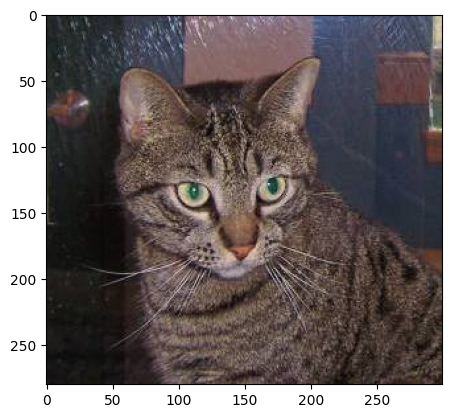

In [73]:
import matplotlib.pyplot as plt

image_path = './data_raw/train/cat.1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

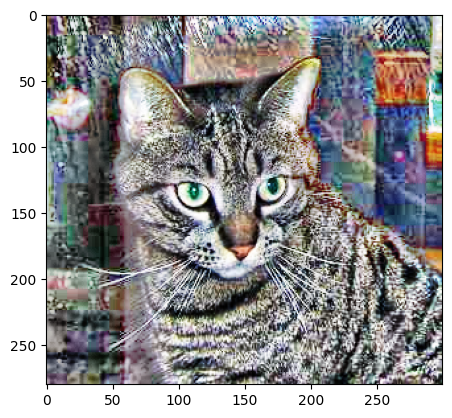

In [74]:
# apply_CLAHE
clahe_image_B = applyCLAHE(image[:, :, 0])
clahe_image_G = applyCLAHE(image[:, :, 1])
clahe_image_R = applyCLAHE(image[:, :, 2])
clahe_image = cv2.merge([clahe_image_B, clahe_image_G, clahe_image_R])
plt.imshow(clahe_image)

In [75]:
import numpy as np
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_image = applySobel(gray_image)
sobel_image

array([[ 0.        ,  0.        ,  0.        , ...,  3.14159265,
         3.14159265,  0.        ],
       [ 1.57079633,  1.24904577,  0.        , ..., -2.32287349,
        -2.35619449, -1.57079633],
       [-1.57079633, -1.71269338, -1.57079633, ..., -1.94378405,
         1.89254688,  1.57079633],
       ...,
       [ 1.57079633,  2.71496516,  2.95848184, ...,  0.46364761,
         0.26147882,  1.57079633],
       [-1.57079633, -3.02216373, -2.98167953, ...,  1.66485756,
         0.        , -1.57079633],
       [ 0.        ,  3.14159265,  3.14159265, ...,  3.14159265,
         0.        ,  0.        ]])

In [79]:
np.min(sobel_image)

-3.139272472138319

In [76]:
hist = hist = cv2.calcHist([sobel_image], [0], None, [256], [0, 256])

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:1008: error: (-210:Unsupported format or combination of formats)  in function 'cv::calcHist'


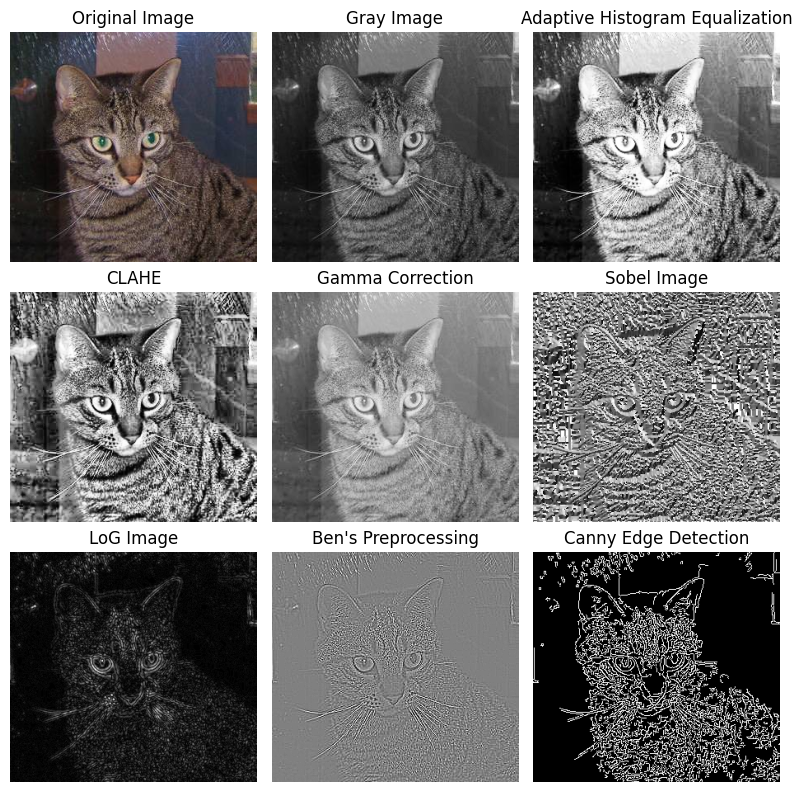

In [34]:
import numpy as np
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)




plt.figure(figsize=(8, 8))

# Display the original image
plt.subplot(3,3, 1)
plt.axis('off')
plt.imshow(image)
plt.title('Original Image')

plt.subplot(3,3, 2)
plt.axis('off')
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')

ahe_image = apply_AHE(gray_image)
plt.subplot(3,3,3)
plt.axis('off')
plt.imshow(ahe_image, cmap='gray')
plt.title('Adaptive Histogram Equalization')

clahe_image = applyCLAHE(gray_image)
plt.subplot(3,3,4)
plt.axis('off')
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE')

# Apply Gamma correction to the grayscale image
gamma_image = applyGamma(gray_image, gamma=2.0)
plt.subplot(3,3,5)
plt.axis('off')
plt.imshow(gamma_image, cmap='gray')
plt.title('Gamma Correction')


# Apply Sobel operator to the grayscale image
sobel_image = applySobel(gray_image)
plt.subplot(3,3,6)
plt.axis('off')
plt.imshow(sobel_image, cmap='gray')
plt.title('Sobel Image')

# Apply Laplacian of Gaussian (LoG) filter to the grayscale image

log_image = applyLoG(gray_image)
plt.subplot(3,3,7)
plt.axis('off')
plt.imshow(log_image, cmap='gray')
plt.title('LoG Image')

# Apply Ben's preprocessing to the grayscale image
ben_image = applyBen(gray_image, size=20)
plt.subplot(3,3,8)
plt.axis('off')
plt.imshow(ben_image, cmap='gray')
plt.title("Ben's Preprocessing")

# Apply Canny edge detection to the grayscale image
canny_image = apply_canny(gray_image)
plt.subplot(3,3,9)
plt.axis('off')
plt.imshow(canny_image, cmap='gray')
plt.title('Canny Edge Detection')



plt.tight_layout()

In [20]:
# show problematic images

import os 

prob_images = os.listdir('./discard')
prob_images

['cat.10266.jpg',
 'cat.10700.jpg',
 'cat.11565.jpg',
 'cat.11724.jpg',
 'cat.12272.jpg',
 'cat.12326.jpg',
 'cat.12493.jpg',
 'cat.1450.jpg',
 'cat.1575.jpg',
 'cat.2520.jpg',
 'cat.2817.jpg',
 'cat.4688.jpg',
 'cat.5355.jpg',
 'cat.5418.jpg',
 'cat.6215.jpg',
 'cat.6987.jpg',
 'cat.7377.jpg',
 'cat.7920.jpg',
 'cat.7968.jpg',
 'cat.92.jpg',
 'cat.9626.jpg',
 'dog.1043.jpg',
 'dog.1815.jpg',
 'dog.1895.jpg',
 'dog.4218.jpg',
 'dog.4367.jpg',
 'dog.4507.jpg',
 'dog.4706.jpg',
 'dog.4927.jpg',
 'dog.5375.jpg',
 'dog.5584.jpg',
 'dog.5604.jpg',
 'dog.6028.jpg',
 'dog.6243.jpg',
 'dog.8277.jpg',
 'dog.8291.jpg',
 'dog.8736.jpg',
 'dog.8898.jpg',
 'dog.9028.jpg',
 'dog.9188.jpg']

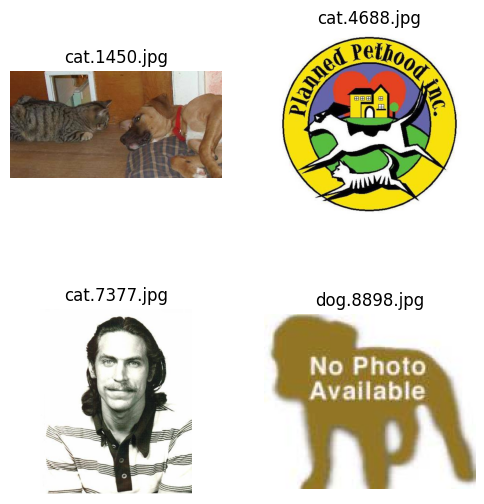

In [25]:
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)

plt. subplot(2, 2, 1)
img = cv2.imread('./discard/cat.1450.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title('cat.1450.jpg')
plt.axis('off')
plt.imshow(img)

plt. subplot(2, 2, 2)
plt.axis('off')
img = cv2.imread('./discard/cat.4688.jpg')
plt.title('cat.4688.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt. subplot(2, 2, 3)
plt.axis('off')
img = cv2.imread('./discard/cat.7377.jpg')
plt.title('cat.7377.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt. subplot(2, 2, 4)
plt.axis('off')
img = cv2.imread('./discard/dog.8898.jpg')
plt.title('dog.8898.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


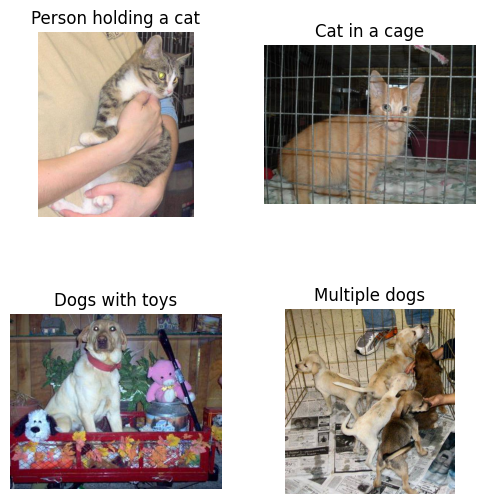

In [26]:
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)

plt. subplot(2, 2, 1)
img = cv2.imread('./data_raw/train/cat.765.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title('Person holding a cat')
plt.axis('off')
plt.imshow(img)

plt. subplot(2, 2, 2)
plt.axis('off')
img = cv2.imread('./data_raw/train/cat.990.jpg')
plt.title('Cat in a cage')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt. subplot(2, 2, 3)
plt.axis('off')
img = cv2.imread('./data_raw/train/dog.7644.jpg')
plt.title('Dogs with toys')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt. subplot(2, 2, 4)
plt.axis('off')
img = cv2.imread('./data_raw/train/dog.7699.jpg')
plt.title('Multiple dogs')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


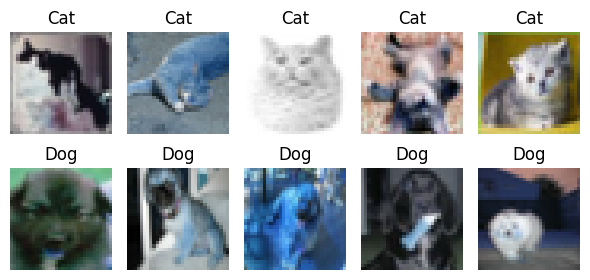

In [31]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths to CIFAR-10 cat and dog images
cifar_10_cats_path = './cifar/train/3/'
cifar_10_dogs_path = './cifar/train/5/'

# Function to load random image file paths from a folder
def load_random_images_from_folder(folder, num_images=5):
    images = [os.path.join(folder, filename) for filename in os.listdir(folder) 
              if filename.endswith('.png') or filename.endswith('.jpg')]
    return random.sample(images, num_images)

# Load 5 random images from each class (cats and dogs)
cat_images = load_random_images_from_folder(cifar_10_cats_path)
dog_images = load_random_images_from_folder(cifar_10_dogs_path)

# Plot the images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(6, 3))

# Plot random cat images
for i, cat_img in enumerate(cat_images):
    img = Image.open(cat_img)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')  # Hide the axes for a cleaner look
    axes[0, i].set_title('Cat')

# Plot random dog images
for i, dog_img in enumerate(dog_images):
    img = Image.open(dog_img)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Dog')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


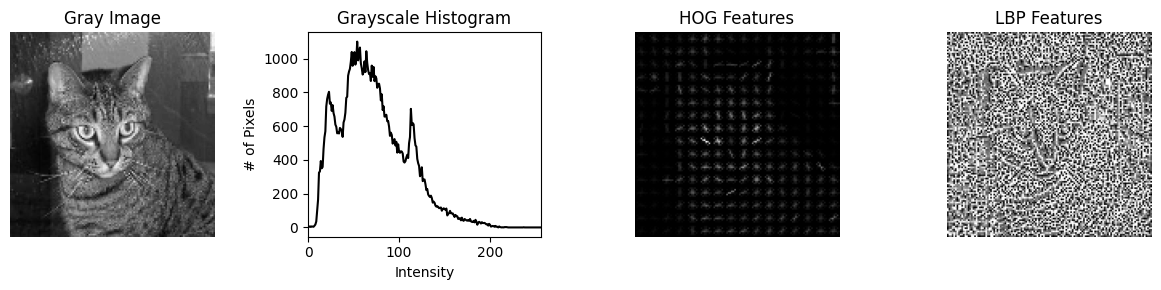

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray

# Function to extract and visualize Color Histogram
def visualize_color_histogram(image):
    chans = cv2.split(image)
    colors = ('b', 'g', 'r')

    plt.subplot(1,4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap='gray')
    plt.title("Gray Image")
    plt.axis('off')

    plt.subplot(1,4, 2)
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    plt.plot(hist, color='black')
    plt.xlim([0, 256])
    plt.title("Grayscale Histogram")
    plt.xlabel("Intensity")
    plt.ylabel("# of Pixels")

# Function to extract and visualize HOG features
def visualize_hog(image):
    gray_image = rgb2gray(image)
    hog_features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    plt.subplot(1,4, 3)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Features")
    plt.axis('off')

# Function to extract and visualize LBP features
def visualize_lbp(image):
    gray_image = rgb2gray(image)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    plt.subplot(1,4, 4)
    plt.imshow(lbp, cmap='gray')
    plt.title("LBP Features")
    plt.axis('off')

# Load an image
def load_and_visualize(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, (128, 128))
    
    # Create a figure to visualize all features
    plt.figure(figsize=(12,3))
    
    # Visualize Color Histogram
    visualize_color_histogram(image_rgb)
    
    # Visualize HOG Features
    visualize_hog(image_rgb)
    
    # Visualize LBP Features
    visualize_lbp(image_rgb)
    
    # Show the final plot
    plt.tight_layout()
    plt.show()

# Example usage with an image path
image_path = './data_raw/train/cat.1.jpg'  # Replace with your image path
load_and_visualize(image_path)
